In [7]:
import string
import pandas as pd
from gensim import corpora
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
import re
import pymongo
import pymongo.database
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

NLTK download

In [8]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\wwwhh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wwwhh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\wwwhh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\wwwhh\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

Query database

In [9]:
def get_all_url():
    my_client: pymongo.MongoClient = pymongo.MongoClient("mongodb://localhost:27017/")
    my_db: pymongo.database.Database = my_client["final-year-project"]
    crawlers_url: pymongo.database.Collection = my_db["crawlers_url"]
    try:
        result = crawlers_url.find()
        return list(result)
    except Exception as e:
        print(f"An error occurred: {e}")
        return []
    
def get_all_content():
    my_client: pymongo.MongoClient = pymongo.MongoClient("mongodb://localhost:27017/")
    my_db: pymongo.database.Database = my_client["final-year-project"]
    crawlers_content: pymongo.database.Collection = my_db["crawlers_content"]
    try:
        result = crawlers_content.find()
        return list(result)
    except Exception as e:
        print(f"An error occurred: {e}")
        return []

In [ ]:
filter_words = ['china', 'chinese', 'sumerian', 'sumerians', 'sumer', 'shang', 'xia', 'cuneiform']

def deduplication(list_of_dicts):
    # Using a set to deduplicate
    deduplicated = []
    text_seen = set()

    for d in list_of_dicts:
        # Convert dict to frozenset
        if d['text'] not in text_seen:
            text_seen.add(d['text'])
            deduplicated.append(d)
            
    return deduplicated

def filter(tokens):
    for word in tokens:
        if word in filter_words:
            return True
        
    return False


def preprocess(text):
    """Preprocess the input text."""
    # Lowercase
    text = text.lower()
    # Remove URLs and email addresses
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\S+@\S+', '', text)
    # Remove punctuation and numbers
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r'\d+', '', text)
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    gensim_stopwords = list(STOPWORDS)
    sklearn_stopwords = list(ENGLISH_STOP_WORDS)
    custom_stopwords = set(['going', 'im', 'one', 'go', 'people', 'say', 'get', 'know', 'think', 'like', 'want', 'make', 'thing', 'good', 'really', 'time', 'look', 'come', 'see', 'would', 'could', 'may', 'might', 'must', 'shall', 'should', 'will', 'ought', 'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten'])
    stop_words = stop_words.union(custom_stopwords)
    stop_words = stop_words.union(gensim_stopwords)
    stop_words = stop_words.union(sklearn_stopwords)
    tokens = [word for word in tokens if word not in stop_words]
    
    if not filter(tokens):
        return ""
    
    # POS tagging
    tagged_tokens = nltk.pos_tag(tokens)
    # Lemmatization and remove adverbs
    lemmatizer = WordNetLemmatizer()
    tokens = [
        lemmatizer.lemmatize(word, pos='v') for word, pos in tagged_tokens if pos[0] != 'R'
    ]
    
    # Remove whitespace and join back into a single string
    tokens = ' '.join(word.strip() for word in tokens if word.strip())
    return tokens

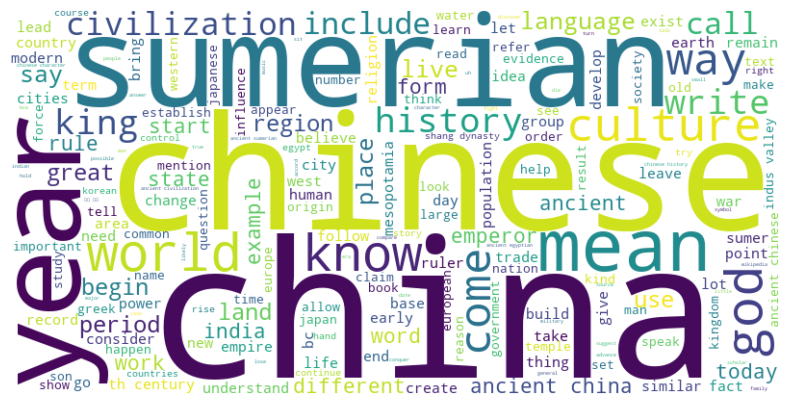

In [ ]:
def wordcloud(texts):
    text_list = set([preprocess(text) for text in texts])


    preprocessed_docs = ' '.join(preprocess(text) for text in text_list)

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(preprocessed_docs)

    # Display the word cloud using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Hide axes
    plt.show()


source
quora      11463
youtube      307
Name: count, dtype: int64


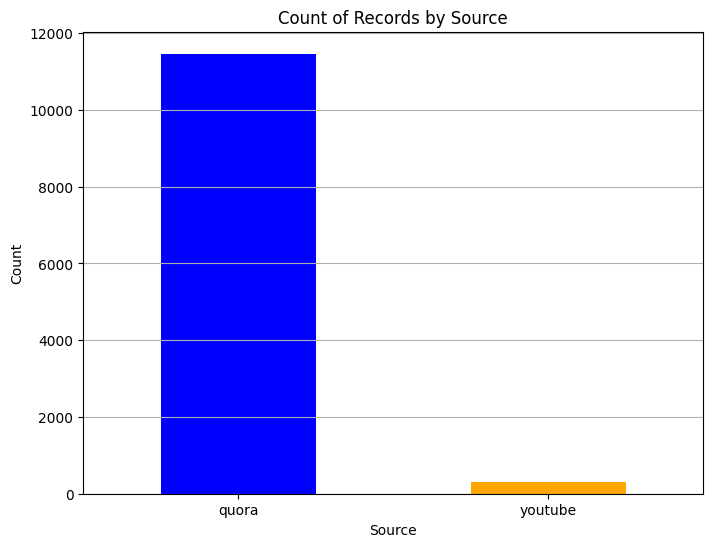

In [ ]:
df = pd.DataFrame(deduplicated)

def record_source(df):
    # Count occurrences by source
    source_counts = df['source'].value_counts()
    # Plotting
    plt.figure(figsize=(8, 6))
    source_counts.plot(kind='bar', color=['blue', 'orange'])
    plt.title('Count of Records by Source')
    plt.xlabel('Source')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.show()

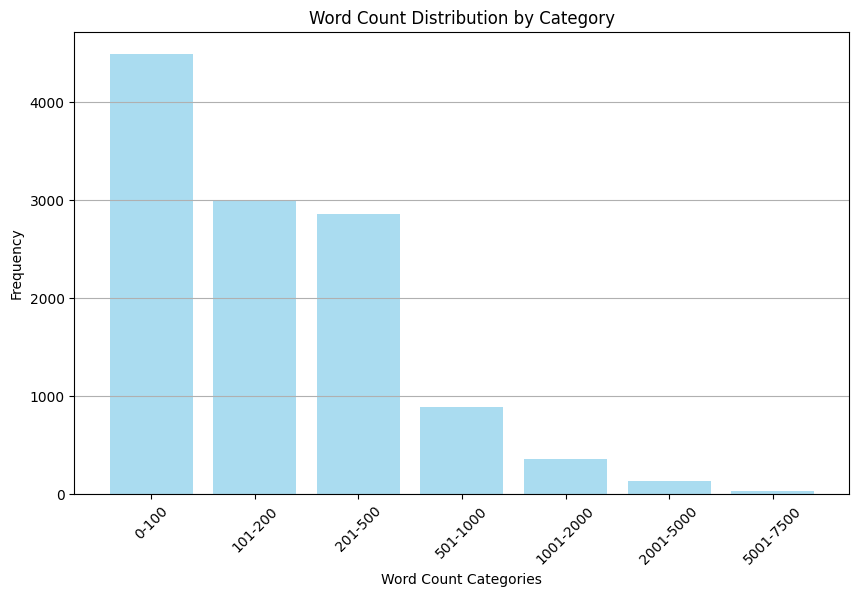

In [13]:
def record_word_count_bar_chart(df):
    # Calculate word count
    df['word_count'] = df['text'].apply(lambda x: len(x.split()))

    # Define bins for word count categories
    bins = [0, 100, 200, 500, 1000, 2000, 5000, 7500]
    labels = ['0-100', '101-200', '201-500', '501-1000', '1001-2000', '2001-5000', '5001-7500']
    
    # Cut the word counts into bins
    df['word_count_category'] = pd.cut(df['word_count'], bins=bins, labels=labels, right=False)
    
    # Count the frequency of each category
    category_counts = df['word_count_category'].value_counts().sort_index()

    # Plotting the bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(category_counts.index, category_counts.values, color='skyblue', alpha=0.7)
    
    # Set title and labels
    plt.title('Word Count Distribution by Category')
    plt.xlabel('Word Count Categories')
    plt.ylabel('Frequency')
    
    plt.xticks(rotation=45)
    
    plt.grid(axis='y')
    
    plt.show()
    
record_word_count_bar_chart(df)